In [1]:
!nvidia-smi

Fri Feb 25 14:57:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
ds_train, ds_info = tfds.load('fashion_mnist', split='train', shuffle_files=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteHO6IMQ/fashion_mnist-train.tfrecord


  0%|          | 0/60000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteHO6IMQ/fashion_mnist-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


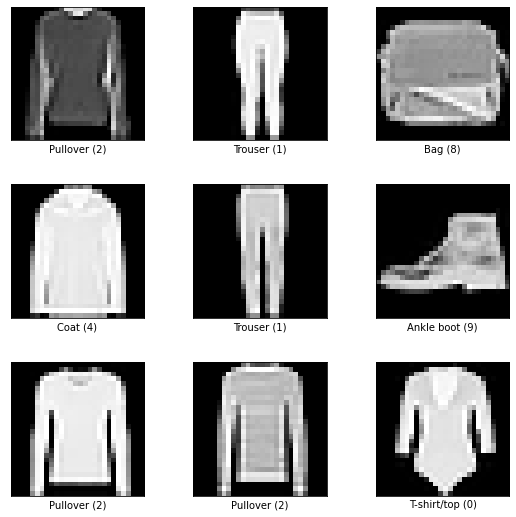

In [5]:
fig = tfds.show_examples(ds_info, ds_train)

In [6]:
ds_info

tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=3.0.1,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning
                   Algorithms},
      journal   = {CoRR},
      volume

In [7]:
batch_size = 200
image_shape = (28,28,1)

def preprocess(features):
    image = tf.image.resize(features['image'],image_shape[:2])
    image = tf.cast(image, tf.float32)
    image = (image - 127.5)/127.5
    return image

In [8]:
ds_train = ds_train.map(preprocess).cache().shuffle(ds_info.splits['train'].num_examples).batch(batch_size).repeat()

In [9]:
train_num = ds_info.splits['train'].num_examples
train_steps_per_epoch = round(train_num/batch_size)
print(train_steps_per_epoch)

300


In [10]:
class GAN():
    def __init__(self, generator, discriminator):
        self.D = discriminator
        self.G = generator
        
        self.bce = tf.keras.losses.BinaryCrossentropy()
        self.d_loss = {}
        self.g_loss = {}
        self.accuracy = {}
        self.g_gradients = []
        
    def discriminator_loss(self, pred_fake, pred_real):
        real_loss = self.bce(tf.ones_like(pred_real), pred_real)
        fake_loss = self.bce(tf.zeros_like(pred_fake), pred_fake)
        
        d_loss = 0.5*(real_loss + fake_loss)
        return d_loss
    
    def generator_loss(self, pred_fake):
        g_loss = self.bce(tf.ones_like(pred_fake), pred_fake)
        return g_loss
    
    def train_step(self, g_input, real_input):
        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
            # Feed forward
            fake_input = self.G(g_input)
            
            pred_fake = self.D(fake_input)
            pred_real = self.D(real_input)
            
            # Calculate losses
            d_loss = self.discriminator_loss(pred_fake, pred_real)
            g_loss = self.generator_loss(pred_fake)
            
            # Accuracy
            fake_accuracy = tf.math.reduce_mean(keras.metrics.binary_accuracy(tf.zeros_like(pred_fake),pred_fake))
            real_accuracy = tf.math.reduce_mean(keras.metrics.binary_accuracy(tf.ones_like(pred_real), pred_real))
            
            # backprop gradients
            gradient_g = g_tape.gradient(g_loss, self.G.trainable_variables)
            gradient_d = d_tape.gradient(d_loss, self.D.trainable_variables)
            
            gradient_g_l1_norm = [tf.norm(gradient).numpy() for gradient in gradient_g]
            self.g_gradients.append(gradient_g_l1_norm)
            # Update weights
            self.G_optimizer.apply_gradients(zip(gradient_g, self.G.trainable_variables))
            self.D_optimizer.apply_gradients(zip(gradient_d, self.D.trainable_variables))
            
        return g_loss, d_loss, fake_accuracy, real_accuracy
    
    def train(self, data_generator, z_generator, g_optimizer, d_optimizer, steps, interval=100):
        self.D_optimizer = d_optimizer
        self.G_optimizer = g_optimizer
        val_g_input = next(z_generator)
        for i in range(steps):
            g_input = next(z_generator)
            real_input = next(data_generator)
            
            g_loss, d_loss, fake_accuracy, real_accuracy = self.train_step(g_input, real_input)
            self.d_loss[i] = d_loss.numpy()
            self.g_loss[i] = g_loss.numpy()
            self.accuracy[i] = 0.5*(fake_accuracy.numpy() + real_accuracy.numpy())
            if i%interval == 0:
                msg = 'Step {}: d_loss {:.4f} g_loss {:.4f} Accuracy. real : {:.3f} fake : {:.3f}'\
                .format(i, d_loss, g_loss, real_accuracy, fake_accuracy)
                print(msg)
                
                fake_images = self.G(val_g_input)
                self.plot_images(fake_images)
                
    def plot_images(self, images):
        pass

In [11]:
class DCGAN(GAN):
    
    def __init__(self, z_dim, input_shape):
        discriminator = self.Discriminator(input_shape)
        generator = self.Generator(z_dim)
        
        GAN.__init__(self, generator, discriminator)
        
    def Discriminator(self, input_shape):
        
        model = tf.keras.Sequential(name='Discriminator')
        model.add(layers.Input(shape=input_shape))
        
        model.add(layers.Conv2D(32, 3, strides=(2,2), padding='same'))
        model.add(layers.BatchNormalization(momentum=0.9))
        model.add(layers.LeakyReLU(0.2))
        model.add(layers.Dropout(0.2))
        
        model.add(layers.Conv2D(64, 3, strides=(2,2), padding='same'))
        model.add(layers.BatchNormalization(momentum=0.9))
        model.add(layers.LeakyReLU(0.2))
        model.add(layers.Dropout(0.2))
        
        model.add(layers.Flatten())
        model.add(layers.Dense(1, activation='sigmoid'))
        
        return model
    
    def Generator(self, z_dim):
        
        model = tf.keras.Sequential(name='Generator')
        model.add(layers.Input(shape=[z_dim]))
        
        model.add(layers.Dense(7*7*64))
        model.add(layers.BatchNormalization(momentum=0.9))
        model.add(layers.ReLU())
        model.add(layers.Reshape((7,7,64)))
        
        model.add(layers.Conv2D(64, 3, padding='same'))
        model.add(layers.BatchNormalization(momentum=0.9))
        model.add(layers.ReLU())
        model.add(layers.UpSampling2D((2,2), interpolation='bilinear'))
        
        model.add(layers.Conv2D(32, 3, padding='same'))
        model.add(layers.ReLU())
        model.add(layers.UpSampling2D((2,2), interpolation='bilinear'))
        
        model.add(layers.Conv2D(image_shape[-1], 3, padding='same', activation='tanh'))
        
        return model
    
    def plot_images(self, images):
        grid_row = 1
        grid_col = 8
        f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col * 1.5, grid_row * 1.5))
        for col in range(grid_col):
            axarr[col].imshow((images[col, :, :, 0] + 1)/2, cmap='gray')
            axarr[col].axis('off')
        plt.show()

In [12]:
z_dim = 100

def z_generator(bacth_size, z_dim):
    while True:
        yield tf.random.normal((batch_size, z_dim))
        
z_gen = z_generator(batch_size, z_dim)

In [13]:
gan = DCGAN(z_dim, image_shape)

In [14]:
gan.D.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 32)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 64)         256       
 hNormalization)                                     

In [15]:
gan.G.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 3136)              316736    
                                                                 
 batch_normalization_2 (Batc  (None, 3136)             12544     
 hNormalization)                                                 
                                                                 
 re_lu (ReLU)                (None, 3136)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 batch_normalization_3 (Batc  (None, 7, 7, 64)         256       
 hNormalization)                                         

Step 0: d_loss 0.7170 g_loss 0.6929 Accuracy. real : 0.045 fake : 0.445


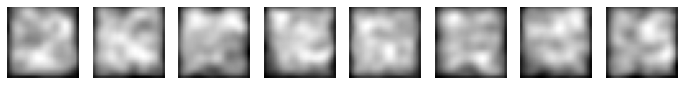

Step 600: d_loss 0.7871 g_loss 0.4430 Accuracy. real : 0.765 fake : 0.055


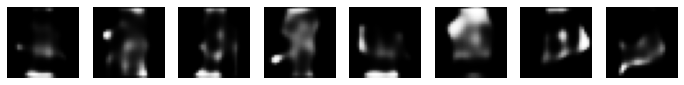

Step 1200: d_loss 0.4906 g_loss 1.0962 Accuracy. real : 0.720 fake : 0.865


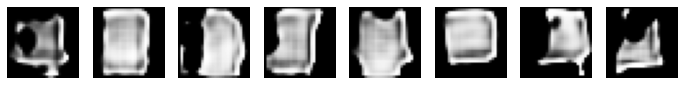

Step 1800: d_loss 0.6856 g_loss 0.9608 Accuracy. real : 0.420 fake : 0.780


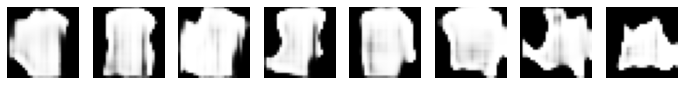

Step 2400: d_loss 0.5638 g_loss 0.8695 Accuracy. real : 0.695 fake : 0.685


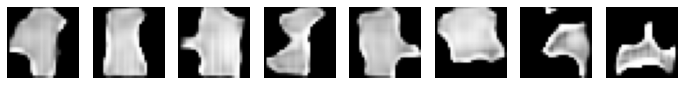

Step 3000: d_loss 0.5140 g_loss 1.0565 Accuracy. real : 0.715 fake : 0.840


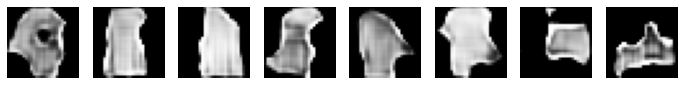

Step 3600: d_loss 0.5974 g_loss 1.1819 Accuracy. real : 0.425 fake : 0.915


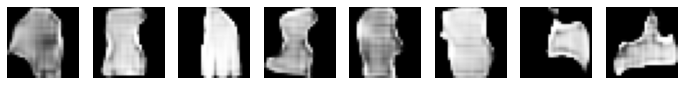

Step 4200: d_loss 0.5504 g_loss 0.7264 Accuracy. real : 0.910 fake : 0.500


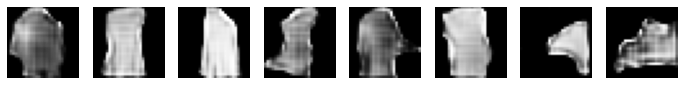

Step 4800: d_loss 0.5242 g_loss 0.9261 Accuracy. real : 0.735 fake : 0.830


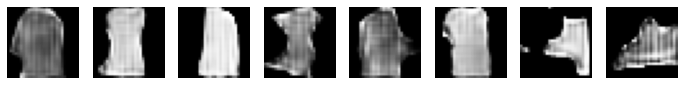

Step 5400: d_loss 0.5432 g_loss 0.7682 Accuracy. real : 0.890 fake : 0.550


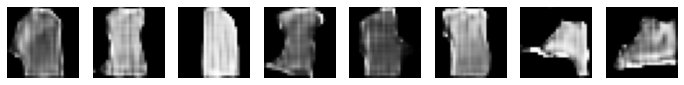

Step 6000: d_loss 0.5233 g_loss 1.7322 Accuracy. real : 0.480 fake : 0.975


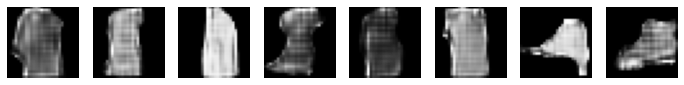

Step 6600: d_loss 0.5209 g_loss 1.2625 Accuracy. real : 0.575 fake : 0.930


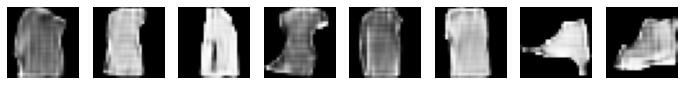

Step 7200: d_loss 0.4738 g_loss 1.5641 Accuracy. real : 0.575 fake : 0.950


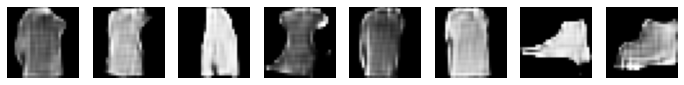

In [16]:
gan.train(iter(ds_train),z_gen,
          keras.optimizers.RMSprop(3e-4), keras.optimizers.RMSprop(3e-4),
          25*train_steps_per_epoch, 2*train_steps_per_epoch)